In [41]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import os
from sklearn.model_selection import train_test_split

In [42]:
def Create_Generator():
    gen = tf.keras.Sequential()
    gen.add(tf.keras.layers.Dense(16*16*384, input_shape=(100,)))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Reshape((16,16,384)))
    gen.add(tf.keras.layers.Conv2DTranspose(192, (5,5), strides=(1,1), padding='same'))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Conv2DTranspose(96, (5,5), strides=(2,2), padding='same'))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Conv2DTranspose(48, (5,5), strides=(2,2), padding='same'))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='sigmoid'))
    
    gen.compile(loss='binary_crossentropy', optimizer='Adam')
    return gen

In [43]:
def Create_Discriminator():
    dis = tf.keras.Sequential()
    
    dis.add(tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    
    dis.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    
    dis.add(tf.keras.layers.Flatten())
    dis.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    dis.compile(loss='binary_crossentropy', optimizer='Adam')
    return dis

In [44]:
def make_trainable(dis, flag):
    dis.trainable = flag
    for l in dis.layers:
        l.trainable = flag
    return dis

In [45]:
def make_noise(n, z):
    return np.random.normal(0, 1, size=(n,z))

In [46]:
def plot_sample(n,z,Generator, index):
    print("Samples:")
    samples = Generator.predict(make_noise(n,z))
    plt.figure(figsize=(15,6))
    for i in range(n):
        plt.subplot(1,n, (i+1))
        plt.imshow(samples[i].reshape(128,128,3))
        plt.axis('off')
    plt.savefig("MNIST_" + str(index) + "_Epochs_Samples",
               bbox_inches='tight',
               pad_inches = 0.5,
               transparent = False,
               dpi =400)
    plt.show()

In [47]:
def LoadAndDecodeImage(imagePath): 
    rawImageData = tf.io.read_file(imagePath)
    imageData = tf.io.decode_jpeg(rawImageData)
    imageData = tf.image.convert_image_dtype(imageData, tf.float32)
    imageData = tf.image.resize(imageData, (128, 128))
    return imageData

In [48]:
def processPath(imagePath):
    return LoadAndDecodeImage(imagePath)

In [49]:
def main():

    path = os.getcwd() + "/img_align_celeba/" 
    dir_list = os.listdir(path)
    for i in range(len(dir_list)):
        dir_list[i] = path + dir_list[i]
    
    ds_file_path = np.array(dir_list)
    trainFiles, testFiles = train_test_split(ds_file_path, train_size=0.7, random_state=42)
    DS = tf.data.Dataset.from_tensor_slices(trainFiles)
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_ds = DS.map(LoadAndDecodeImage, num_parallel_calls=AUTOTUNE)
    
    train_np = tfds.as_numpy(train_ds)
    
    train_list = []
    for images in train_np:
        train_list.append(images)
        
    X_train = np.array(train_list)
    
    epochs = 10
    batch_size = 256
    input_dim = 100
    batch_no = int(len(X_train)/batch_size)
    Generator_Errors, Discriminator_Errors = (list(),list())
    
    Generator = Create_Generator()
    Discriminator = Create_Discriminator()
    
    np.random.seed(42)
    Discriminator = make_trainable(Discriminator, False)
    inputs = tf.keras.Input(shape=(100, ))
    fakes = Generator(inputs)
    output = Discriminator(fakes)
    Gan = tf.keras.Model(inputs,output)
    Gan.compile(loss='binary_crossentropy', optimizer='Adam')
    

    
    for i in range(0, epochs):
        for j in range(batch_no):
            
            rand_sample = np.random.randint(0, len(X_train), size=batch_size)
           
            image_batch = X_train[rand_sample]
            
            input_noise = make_noise(batch_size, input_dim)
            generated_images = Generator.predict(input_noise)
            print(generated_images.shape)
            print(image_batch.shape)
            
            X = np.concatenate((image_batch,generated_images))
            
            
            Y = np.concatenate([[0.9] * batch_size, [0.0] * batch_size])
            
            
            
            print(X.shape)
            print(Y.shape)
            
            Discriminator = make_trainable(Discriminator, True)
            Discriminator_Loss = Discriminator.train_on_batch(X,Y)
            Discriminator = make_trainable(Discriminator, False)
            
            
            input_noise = make_noise(batch_size, input_dim)
            fake_img = np.ones(batch_size)
            for _ in range(4):
                Generator_Loss = Gan.train_on_batch(input_noise, fake_img)

        Generator_Errors.append(Generator_Loss)
        Discriminator_Errors.append(Discriminator_Loss)
        
        if i % 10 == 0:
            print("Epoch %i" % i)
            plot_sample(5, input_dim, Generator, i)
    
    plt.figure(figsize=(15, 5))
    plt.plot(Discriminator_Errors, label='discriminitive loss')
    plt.plot(Generator_Errors, label='generative loss')
    plt.legend()
    plt.show()
    
    Generator.save("Generator_Faces.h5")

8/8 [==============================] - 5s 594ms/step
(256, 128, 128, 3)
(256, 128, 128, 3)
(512, 128, 128, 3)
(512,)
8/8 [==============================] - 4s 487ms/step
(256, 128, 128, 3)
(256, 128, 128, 3)
(512, 128, 128, 3)
(512,)
8/8 [==============================] - 4s 499ms/step
(256, 128, 128, 3)
(256, 128, 128, 3)
(512, 128, 128, 3)
(512,)
Epoch 0
Samples:
1/1 [==============================] - 0s 294ms/step


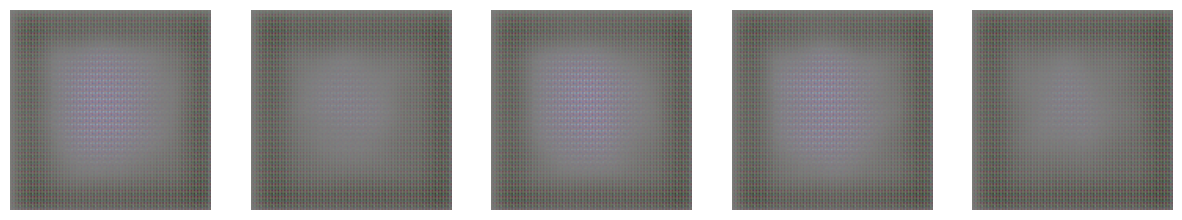

8/8 [==============================] - 5s 620ms/step
(256, 128, 128, 3)
(256, 128, 128, 3)
(512, 128, 128, 3)
(512,)


KeyboardInterrupt: 

In [50]:
if __name__ == '__main__':
    main()